In [252]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, ParameterGrid
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt


# Загрузка датафрейма

In [253]:
df = pd.read_csv('glass.csv', dtype = {'RI': 'float64',
                                       'Na': 'float64',
                                       'MG': 'float64',
                                       'Al': 'float64',
                                       'Si': 'float64',
                                       'K': 'float64',
                                       'Ca': 'float64',
                                       'Ba': 'float64',
                                       'Fe': 'float64',
                                       'type': 'int64'
                                       })
df

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


# Стандартизация

In [254]:
numeric_columns = df.columns[:-1]
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numeric_columns] = scaler.fit_transform(df[numeric_columns])
df_scaled

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,0.872868,0.284953,1.254639,-0.692442,-1.127082,-0.671705,-0.145766,-0.352877,-0.586451,1
1,-0.249333,0.591817,0.636168,-0.170460,0.102319,-0.026213,-0.793734,-0.352877,-0.586451,1
2,-0.721318,0.149933,0.601422,0.190912,0.438787,-0.164533,-0.828949,-0.352877,-0.586451,1
3,-0.232831,-0.242853,0.698710,-0.310994,-0.052974,0.112107,-0.519052,-0.352877,-0.586451,1
4,-0.312045,-0.169205,0.650066,-0.411375,0.555256,0.081369,-0.624699,-0.352877,-0.586451,1
...,...,...,...,...,...,...,...,...,...,...
209,-0.704815,0.898681,-1.865511,2.881125,-0.052974,-0.640968,0.157088,1.783978,-0.586451,7
210,-0.500178,1.856097,-1.865511,1.094342,0.529374,-0.763919,-0.392276,2.852405,-0.586451,7
211,0.754046,1.168721,-1.865511,1.154570,0.995252,-0.763919,-0.364103,2.953200,-0.586451,7
212,-0.612399,1.193270,-1.865511,0.993960,1.241133,-0.763919,-0.335931,2.812087,-0.586451,7


# Разделение данных 

In [255]:
X = df.drop('Type', axis=1)  
y = df['Type']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=21)


# Поиск лучших параметров для дерева

In [256]:
class tqdmGridSearchCV(GridSearchCV):
    def _run_search(self, evaluate_candidates):
        par = ParameterGrid(self.param_grid)
        for i in tqdm(par):
            evaluate_candidates([i])


tree = DecisionTreeClassifier(random_state=21)
params = {
    'ccp_alpha': [0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.2, 0.8], 
    'criterion': ['entropy', 'gini'],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10]
}
scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',

}
gs = tqdmGridSearchCV(tree, params, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1)
gs.fit(X=X_train, y=y_train)
print(f'Best parameters {gs.best_params_}')
print(f'Best score {gs.best_score_}')


100%|██████████| 270/270 [00:08<00:00, 32.74it/s]

Best parameters {'ccp_alpha': 0.005, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}
Best score 0.7344615384615386


# Вычисляем метрики

In [257]:
best_tree = DecisionTreeClassifier(**gs.best_params_, random_state=21)
best_tree.fit(X_train, y_train)
y_pred = best_tree.predict(X_test)
y_pred_proba = best_tree.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-Score: {f1:.4f}")

ROC-AUC: 0.7973
F1-Score: 0.6870


# Визуализация дерева

In [258]:
def create_tree(model: DecisionTreeClassifier) -> None:
    plt.figure(figsize=(16, 10))
    plot_tree(model, 
            feature_names=df.columns[:-1], 
            class_names=df["Type"].astype(str), 
            filled=True,
            proportion=False,
            fontsize=5,
            label='all')
    plt.tight_layout()
    plt.title('best_tree', fontsize=25, weight='bold')
    plt.show()



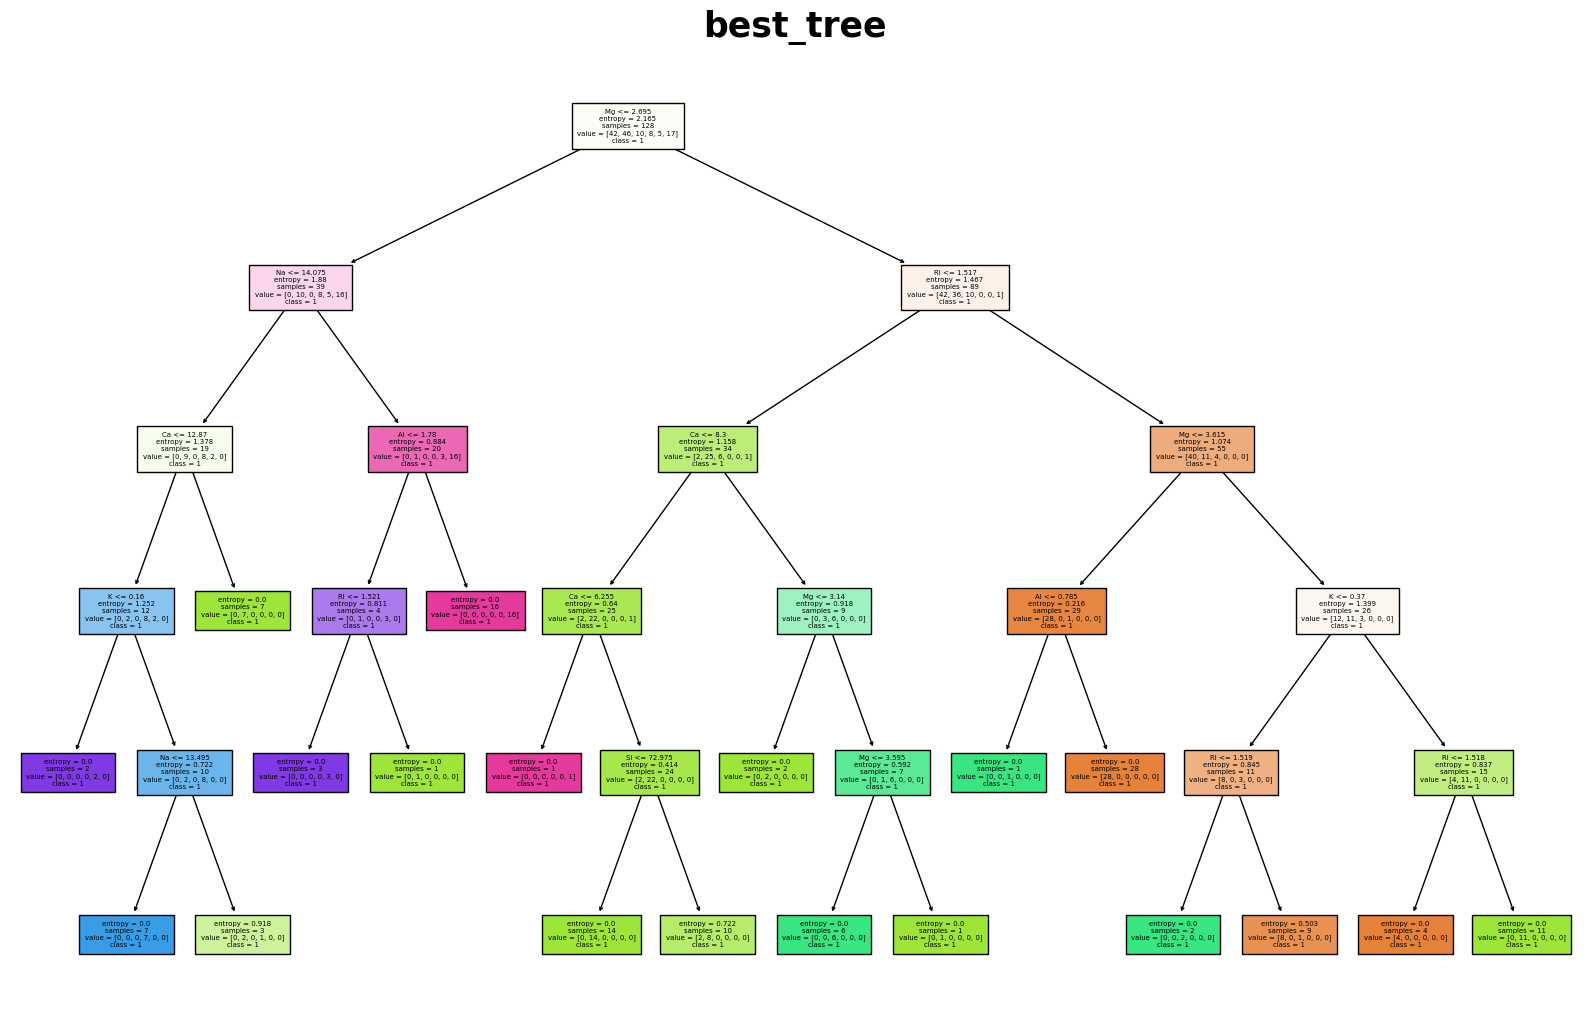

In [259]:
best_tree = gs.best_estimator_
best_tree.fit(X_train, y_train)
create_tree(best_tree)

In [260]:
pca = PCA()
pca.fit(X_train)
cumsum = pca.explained_variance_ratio_.cumsum()
n_components_95 = (cumsum >= 0.95).argmax() + 1
print(f'Количество компонент для 95% дисперсии: {n_components_95}')
pca = PCA(n_components=n_components_95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


tree_pca = DecisionTreeClassifier(**gs.best_params_)
tree_pca.fit(X_train_pca, y_train)

accuracy_pca = tree_pca.score(X_test_pca, y_test)
print(f'Точность дерева без PCA: {gs.best_score_:.4f}')
print(f'Точность дерева с PCA: {accuracy_pca:.4f}')

Количество компонент для 95% дисперсии: 4
Точность дерева без PCA: 0.7345
Точность дерева с PCA: 0.5465


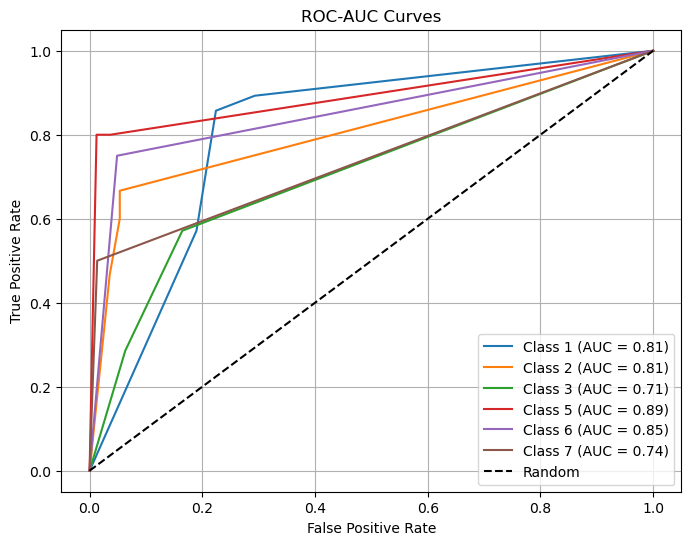

[[0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 0 1]
 [0 1 0 0 0 0]
 [0 0 0 0 0 1]
 [1 0 0 0 0 0]
 [0 0 0 0 0 1]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 1 0]
 [1 0 0 0 0 0]
 [0 0 0 0 0 1]
 [1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 1 0 0]
 [1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 1 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 1 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 0 1]
 [1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 1]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 1 0 0 

In [ ]:
def roc_auc(y_true, y_pred_proba, classes) -> None:
    y_true_bin = label_binarize(y_true, classes=classes)
    plt.figure(figsize=(8, 6))
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {classes[i]} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curves')
    plt.legend()
    plt.grid(True)
    plt.show()
    
roc_auc(y_test, y_pred_proba, best_tree.classes_)
